# Capstone Project - The Risk of Sexual Assault on Mexico City
### By: Erik Delgadillo López
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction:Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Problem <a name="introduction"></a>

In this project we will try to unravel the data provided by the **Mexico City** (CDMX) government about the **Sexual Assault** on it and about the **gender crisis** that the city is living trough.

In the last 5 years it became more evident the increase of "violent sexual assault crimes on the streets" formally called as "Rape", we will navigate trough the raw information and make it lookable and readable in a way to be easy to understand and assimilate for any concerned citizen aware of this severe problem and proportionate a fidelity map based on reliable source of information to graphically understand the problem.

## Data <a name="data"></a>

In order to unravel the data we want to answer the most important questions about it:

* how many reported "Rapes" exist?

* where are located the considered "high risk areas"?

* how severe has become the situation compared with other periods of time?

We decided obtain the data from the most reliable source in this matter.
we have in our disposal:

* the public data base of all the opened investigations by the Justice Department A.K.A **"Procuraduria General de justicia"** with URL: https://datos.cdmx.gob.mx/explore/dataset/carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico/table/?disjunctive.ao_hechos&disjunctive.delito

* Geojson file with the exact location and delimitation of all the CDMX boroughs with URL: https://datos.cdmx.gob.mx/explore/dataset/alcaldias/table/

* Database of the reported crimes with known adresses and an aggregate of "Latitude" and "Longitude" obtained for the previous wrangled API consult*. 

**(it is important to make a clarification, we will ignore the crime reports with a reported borough different from the 16 official alcaldias, and for our "point map" we will either exclude the  crime reports without Lat, Long Data.)**

#### On this section of the code we will consult the number of open investigations one by one because they have different url, we will take in count only the data obtained since 2016 because that was the year that the open investigations became a digital reliable source and not only for physical consult.

In [ ]:
#we import the libraries
import json
import requests
import pandas as pd
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print('Folium installed and imported!')
import numpy as np
from folium import plugins

## Year 2016 <a name="Year 2016"></a>

We'll create a df of crime occurrence by month on year 2016

In [3]:
#we get the json url from the api consult on the browser for 2016
url="https://datos.cdmx.gob.mx/api/records/1.0/search/?dataset=carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico&rows=619&facet=ao_hechos&facet=mes_hechos&facet=delito&facet=categoria_delito&facet=fiscalia&facet=alcaldia_hechos&facet=colonia_hechos&facet=ao_inicio&facet=mes_inicio&refine.ao_hechos=2016&refine.categoria_delito=VIOLACI%C3%93N"
consulta_general = requests.get(url).json()
# assign relevant part of JSON to venues
delitos = consulta_general['records']
# tranform venues into a dataframe
df = json_normalize(delitos)
#we filter the relevant columns
filtered_columns=['fields.delito','fields.alcaldia_hechos','fields.mes_hechos','fields.fecha_hechos','fields.ao_inicio','recordid']
dataframe2016 = df.loc[:, filtered_columns]
# we clean the tiltes
dataframe2016.columns = [column.split('.')[-1] for column in dataframe2016.columns]
#we stablish delito as index in order to use iloc 
dataframe2016.set_index("delito", inplace=True)
#we only select "violación" and violacion tumultaria
dff2016=dataframe2016.loc[['VIOLACION','VIOLACION TUMULTUARIA']]
#we reset index in order to plotting the map
dff2016.reset_index(inplace=True)
# Rename some of the columns so that they make sense.
dff2016.rename(columns={'ao_inicio':'Year_of_Incident','alcaldia_hechos':'Alcaldia', 'mes_hechos':'Month_of_Incident','fecha_hechos':'Date_of_incident','recordid':'Crime_ID','delito':'Category'}, inplace=True)
# we only take on count the felonies reported on the same year
dff2016_m= dff2016[dff2016.Year_of_Incident=='2016']
#then for homologation process with the other dataframes we'll exclude all the "not official or wrong alcaldias"
#we want to construct a simple df with the ocurrence by alcaldia
#first we drop all the unoficial or wrong captured "alcaldias"
dff2016_m.set_index("Alcaldia", inplace=True)
#we only select "16 official ones"
dff_2016_month_alc=dff2016_m.loc[['ALVARO OBREGON','AZCAPOTZALCO','BENITO JUAREZ','COYOACAN','CUAJIMALPA DE MORELOS','CUAUHTEMOC','GUSTAVO A MADERO','IZTACALCO','IZTAPALAPA','LA MAGDALENA CONTRERAS','MIGUEL HIDALGO','MILPA ALTA','TLAHUAC','TLALPAN','VENUSTIANO CARRANZA','XOCHIMILCO']]
#we reset index in order to plotting the map
dff_2016_month_alc.reset_index(inplace=True)
#we want to construct a simple df with the ocurrence by month
#we filter again the relevant columns
filtered_columns=['Month_of_Incident','Crime_ID']
dff_2016 = dff_2016_month_alc.loc[:, filtered_columns]
#this variable keeps the total incident of the year
year_2016=dff_2016.shape[0]
#we create 2 list,one with the occurrence for every alcaldia and
#another with the name of the alcaldias
list_of_2016=dff_2016.groupby('Month_of_Incident').size().to_list()
list_months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
dff_2016_months= pd.DataFrame(list(zip(list_months,list_of_2016)), 
               columns =['Month', 'Crime_rate_2016']) 
dff_2016_months.shape

(12, 2)

Now we'll create a df of crime occurrence by Borough on year 2016

In [4]:
#we get the json url from the api consult on the browser for 2016
url="https://datos.cdmx.gob.mx/api/records/1.0/search/?dataset=carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico&rows=619&facet=ao_hechos&facet=mes_hechos&facet=delito&facet=categoria_delito&facet=fiscalia&facet=alcaldia_hechos&facet=colonia_hechos&facet=ao_inicio&facet=mes_inicio&refine.ao_hechos=2016&refine.categoria_delito=VIOLACI%C3%93N"
consulta_general = requests.get(url).json()
# assign relevant part of JSON to venues
delitos = consulta_general['records']
# tranform venues into a dataframe
df = json_normalize(delitos)
#we filter the relevant columns
filtered_columns=['fields.delito','fields.alcaldia_hechos','fields.mes_hechos','fields.fecha_hechos','fields.ao_inicio','recordid']
dataframe2016 = df.loc[:, filtered_columns]
# we clean the tiltes
dataframe2016.columns = [column.split('.')[-1] for column in dataframe2016.columns]
#we stablish delito as index in order to use iloc 
dataframe2016.set_index("delito", inplace=True)
#we only select "violación" and violacion tumultaria
dff2016=dataframe2016.loc[['VIOLACION','VIOLACION TUMULTUARIA']]
#we reset index in order to plotting the map
dff2016.reset_index(inplace=True)
# Rename some of the columns so that they make sense.
dff2016.rename(columns={'ao_inicio':'Year_of_Incident','alcaldia_hechos':'Alcaldia', 'mes_hechos':'Month_of_Incident','fecha_hechos':'Date_of_incident','recordid':'Crime_ID','delito':'Category'}, inplace=True)
# we only take on count the felonies reported on the same year
dff2016_a= dff2016[dff2016.Year_of_Incident=='2016']
#we want to construct a simple df with the ocurrence by alcaldia
#first we drop all the unoficial or wrong captured "alcaldias"
dff2016_a.set_index("Alcaldia", inplace=True)
#we only select "violación" and violacion tumultaria
dff_2016_alc=dff2016_a.loc[['ALVARO OBREGON','AZCAPOTZALCO','BENITO JUAREZ','COYOACAN','CUAJIMALPA DE MORELOS','CUAUHTEMOC','GUSTAVO A MADERO','IZTACALCO','IZTAPALAPA','LA MAGDALENA CONTRERAS','MIGUEL HIDALGO','MILPA ALTA','TLAHUAC','TLALPAN','VENUSTIANO CARRANZA','XOCHIMILCO']]
#we reset index in order to plotting the map
dff_2016_alc.reset_index(inplace=True)
#we filter again the relevant columns
filtered_columns=['Alcaldia','Crime_ID']
dff_2016_alcaldia = dff_2016_alc.loc[:, filtered_columns]
#we create 2 list,one with the occurrence for every alcaldia and
#another with the name of the alcaldias
list_of_2016_alcaldias=dff_2016_alcaldia.groupby('Alcaldia').size().to_list()
list_alcaldias=["ALVARO OBREGON","AZCAPOTZALCO","BENITO JUAREZ","COYOACAN","CUAJIMALPA DE MORELOS","CUAUHTEMOC","GUSTAVO A MADERO","IZTACALCO","IZTAPALAPA","LA MAGDALENA CONTRERAS","MIGUEL HIDALGO","MILPA ALTA","TLAHUAC","TLALPAN","VENUSTIANO CARRANZA","XOCHIMILCO"]
dff_2016_alcaldias= pd.DataFrame(list(zip(list_alcaldias,list_of_2016_alcaldias)), 
               columns =['Alcaldia', 'Crime_rate_2016']) 
dff_2016_alc = dff_2016_alcaldias
dff_2016_alc.shape

(16, 2)

## Year 2017

We'll create a df of crime occurrence by month on year 2017

In [5]:
#we get the json url from the api consult on the browser for 2017
url="https://datos.cdmx.gob.mx/api/records/1.0/search/?dataset=carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico&rows=396&facet=ao_hechos&facet=mes_hechos&facet=delito&facet=categoria_delito&facet=fiscalia&facet=alcaldia_hechos&facet=colonia_hechos&facet=ao_inicio&facet=mes_inicio&refine.ao_hechos=2017&refine.categoria_delito=VIOLACI%C3%93N"
consulta_general = requests.get(url).json()
# assign relevant part of JSON to venues
delitos = consulta_general['records']
# tranform venues into a dataframe
df = json_normalize(delitos)
#we filter the relevant columns
filtered_columns=['fields.delito','fields.alcaldia_hechos','fields.mes_hechos','fields.fecha_hechos','fields.ao_inicio','recordid']
dataframe2017 = df.loc[:, filtered_columns]
# we clean the tiltes
dataframe2017.columns = [column.split('.')[-1] for column in dataframe2017.columns]
#we stablish delito as index in order to use iloc 
dataframe2017.set_index("delito", inplace=True)
#we only select "violación" and violacion tumultaria
dff2017=dataframe2017.loc[['VIOLACION','VIOLACION TUMULTUARIA']]
#we reset index in order to plotting the map
dff2017.reset_index(inplace=True)
# Rename some of the columns so that they make sense.
dff2017.rename(columns={'ao_inicio':'Year_of_Incident','alcaldia_hechos':'Alcaldia', 'mes_hechos':'Month_of_Incident','fecha_hechos':'Date_of_incident','recordid':'Crime_ID','delito':'Category'}, inplace=True)
# we only take on count the felonies reported on the same year
dff2017_m= dff2017[dff2017.Year_of_Incident=='2017']
#then for homologation process with the other dataframes we'll exclude all the "not official or wrong alcaldias"
#we want to construct a simple df with the ocurrence by alcaldia
#first we drop all the unoficial or wrong captured "alcaldias"
dff2017_m.set_index("Alcaldia", inplace=True)
#we only select "16 official ones"
dff_2017_month_alc=dff2017_m.loc[['ALVARO OBREGON','AZCAPOTZALCO','BENITO JUAREZ','COYOACAN','CUAJIMALPA DE MORELOS','CUAUHTEMOC','GUSTAVO A MADERO','IZTACALCO','IZTAPALAPA','LA MAGDALENA CONTRERAS','MIGUEL HIDALGO','MILPA ALTA','TLAHUAC','TLALPAN','VENUSTIANO CARRANZA','XOCHIMILCO']]
#we reset index in order to plotting the map
dff_2017_month_alc.reset_index(inplace=True)
#we want to construct a simple df with the ocurrence by month
#we filter again the relevant columns
filtered_columns=['Month_of_Incident','Crime_ID']
dff_2017 = dff_2017_month_alc.loc[:, filtered_columns]
#this variable keeps the total incident of the year
year_2017=dff_2017.shape[0]
#we create 2 list,one with the occurrence for every alcaldia and
#another with the name of the alcaldias
list_of_2017=dff_2017.groupby('Month_of_Incident').size().to_list()
list_months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
dff_2017_months= pd.DataFrame(list(zip(list_months,list_of_2017)), 
               columns =['Month', 'Crime_rate_2017']) 
dff_2017_months.shape

(12, 2)

Now we'll create a df of crime occurrence by Borough on year 2017

In [6]:
#we get the json url from the api consult on the browser for 2017
url="https://datos.cdmx.gob.mx/api/records/1.0/search/?dataset=carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico&rows=396&facet=ao_hechos&facet=mes_hechos&facet=delito&facet=categoria_delito&facet=fiscalia&facet=alcaldia_hechos&facet=colonia_hechos&facet=ao_inicio&facet=mes_inicio&refine.ao_hechos=2017&refine.categoria_delito=VIOLACI%C3%93N"
consulta_general = requests.get(url).json()
# assign relevant part of JSON to venues
delitos = consulta_general['records']
# tranform venues into a dataframe
df = json_normalize(delitos)
#we filter the relevant columns
filtered_columns=['fields.delito','fields.alcaldia_hechos','fields.mes_hechos','fields.fecha_hechos','fields.ao_inicio','recordid']
dataframe2017 = df.loc[:, filtered_columns]
# we clean the tiltes
dataframe2017.columns = [column.split('.')[-1] for column in dataframe2017.columns]
#we stablish delito as index in order to use iloc 
dataframe2017.set_index("delito", inplace=True)
#we only select "violación" and violacion tumultaria
dff2017=dataframe2017.loc[['VIOLACION','VIOLACION TUMULTUARIA']]
#we reset index in order to plotting the map
dff2017.reset_index(inplace=True)
# Rename some of the columns so that they make sense.
dff2017.rename(columns={'ao_inicio':'Year_of_Incident','alcaldia_hechos':'Alcaldia', 'mes_hechos':'Month_of_Incident','fecha_hechos':'Date_of_incident','recordid':'Crime_ID','delito':'Category'}, inplace=True)
# we only take on count the felonies reported on the same year
dff2017_a= dff2017[dff2017.Year_of_Incident=='2017']
#we want to construct a simple df with the ocurrence by alcaldia
#first we drop all the unoficial or wrong captured "alcaldias"
dff2017_a.set_index("Alcaldia", inplace=True)
#we only select "violación" and violacion tumultaria
dff_2017_alc=dff2017_a.loc[['ALVARO OBREGON','AZCAPOTZALCO','BENITO JUAREZ','COYOACAN','CUAJIMALPA DE MORELOS','CUAUHTEMOC','GUSTAVO A MADERO','IZTACALCO','IZTAPALAPA','LA MAGDALENA CONTRERAS','MIGUEL HIDALGO','MILPA ALTA','TLAHUAC','TLALPAN','VENUSTIANO CARRANZA','XOCHIMILCO']]
#we reset index in order to plotting the map
dff_2017_alc.reset_index(inplace=True)
#we filter again the relevant columns
filtered_columns=['Alcaldia','Crime_ID']
dff_2017_alcaldia = dff_2017_alc.loc[:, filtered_columns]
#we create 2 list,one with the occurrence for every alcaldia and
#another with the name of the alcaldias
list_of_2017_alcaldias=dff_2017_alcaldia.groupby('Alcaldia').size().to_list()
list_alcaldias=["ALVARO OBREGON","AZCAPOTZALCO","BENITO JUAREZ","COYOACAN","CUAJIMALPA DE MORELOS","CUAUHTEMOC","GUSTAVO A MADERO","IZTACALCO","IZTAPALAPA","LA MAGDALENA CONTRERAS","MIGUEL HIDALGO","MILPA ALTA","TLAHUAC","TLALPAN","VENUSTIANO CARRANZA","XOCHIMILCO"]
dff_2017_alcaldias= pd.DataFrame(list(zip(list_alcaldias,list_of_2017_alcaldias)), 
               columns =['Alcaldia', 'Crime_rate_2017']) 
dff_2017_alc = dff_2017_alcaldias
dff_2017_alc.shape

(16, 2)

## Year 2018

We'll create a df of crime occurrence by month on year 2018

In [7]:
#we get the json url from the api consult on the browser for 2018
url="https://datos.cdmx.gob.mx/api/records/1.0/search/?dataset=carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico&rows=1396&facet=ao_hechos&facet=mes_hechos&facet=delito&facet=categoria_delito&facet=fiscalia&facet=alcaldia_hechos&facet=colonia_hechos&facet=ao_inicio&facet=mes_inicio&refine.ao_hechos=2018&refine.categoria_delito=VIOLACI%C3%93N"
consulta_general = requests.get(url).json()
# assign relevant part of JSON to venues
delitos = consulta_general['records']
# tranform venues into a dataframe
df = json_normalize(delitos)
#we filter the relevant columns
filtered_columns=['fields.delito','fields.alcaldia_hechos','fields.mes_hechos','fields.fecha_hechos','fields.ao_inicio','recordid']
dataframe2018 = df.loc[:, filtered_columns]
# we clean the tiltes
dataframe2018.columns = [column.split('.')[-1] for column in dataframe2018.columns]
#we stablish delito as index in order to use iloc 
dataframe2018.set_index("delito", inplace=True)
#we only select "violación" and violacion tumultaria
dff2018=dataframe2018.loc[['VIOLACION','VIOLACION TUMULTUARIA']]
#we reset index in order to plotting the map
dff2018.reset_index(inplace=True)
# Rename some of the columns so that they make sense.
dff2018.rename(columns={'ao_inicio':'Year_of_Incident','alcaldia_hechos':'Alcaldia', 'mes_hechos':'Month_of_Incident','fecha_hechos':'Date_of_incident','recordid':'Crime_ID','delito':'Category'}, inplace=True)
# we only take on count the felonies reported on the same year
dff2018_m= dff2018[dff2018.Year_of_Incident=='2018']
#then for homologation process with the other dataframes we'll exclude all the "not official or wrong alcaldias"
#we want to construct a simple df with the ocurrence by alcaldia
#first we drop all the unoficial or wrong captured "alcaldias"
dff2018_m.set_index("Alcaldia", inplace=True)
#we only select "16 official ones"
dff_2018_month_alc=dff2018_m.loc[['ALVARO OBREGON','AZCAPOTZALCO','BENITO JUAREZ','COYOACAN','CUAJIMALPA DE MORELOS','CUAUHTEMOC','GUSTAVO A MADERO','IZTACALCO','IZTAPALAPA','LA MAGDALENA CONTRERAS','MIGUEL HIDALGO','MILPA ALTA','TLAHUAC','TLALPAN','VENUSTIANO CARRANZA','XOCHIMILCO']]
#we reset index in order to plotting the map
dff_2018_month_alc.reset_index(inplace=True)
#we want to construct a simple df with the ocurrence by month
#we filter again the relevant columns
filtered_columns=['Month_of_Incident','Crime_ID']
dff_2018 = dff_2018_month_alc.loc[:, filtered_columns]
#this variable keeps the total incident of the year
year_2018=dff_2018.shape[0]
#we create 2 list,one with the occurrence for every alcaldia and
#another with the name of the alcaldias
list_of_2018=dff_2018.groupby('Month_of_Incident').size().to_list()
list_months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
dff_2018_months= pd.DataFrame(list(zip(list_months,list_of_2018)), 
               columns =['Month', 'Crime_rate_2018']) 
dff_2018_months.shape

(12, 2)

Now we'll create a df of crime occurrence by Borough on year 2018

In [9]:
#we get the json url from the api consult on the browser for 2017
url="https://datos.cdmx.gob.mx/api/records/1.0/search/?dataset=carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico&rows=1396&facet=ao_hechos&facet=mes_hechos&facet=delito&facet=categoria_delito&facet=fiscalia&facet=alcaldia_hechos&facet=colonia_hechos&facet=ao_inicio&facet=mes_inicio&refine.ao_hechos=2018&refine.categoria_delito=VIOLACI%C3%93N"
consulta_general = requests.get(url).json()
# assign relevant part of JSON to venues
delitos = consulta_general['records']
# tranform venues into a dataframe
df = json_normalize(delitos)
#we filter the relevant columns
filtered_columns=['fields.delito','fields.alcaldia_hechos','fields.mes_hechos','fields.fecha_hechos','fields.ao_inicio','recordid']
dataframe2018 = df.loc[:, filtered_columns]
# we clean the tiltes
dataframe2018.columns = [column.split('.')[-1] for column in dataframe2018.columns]
#we stablish delito as index in order to use iloc 
dataframe2018.set_index("delito", inplace=True)
#we only select "violación" and violacion tumultaria
dff2018=dataframe2018.loc[['VIOLACION','VIOLACION TUMULTUARIA']]
#we reset index in order to plotting the map
dff2018.reset_index(inplace=True)
# Rename some of the columns so that they make sense.
dff2018.rename(columns={'ao_inicio':'Year_of_Incident','alcaldia_hechos':'Alcaldia', 'mes_hechos':'Month_of_Incident','fecha_hechos':'Date_of_incident','recordid':'Crime_ID','delito':'Category'}, inplace=True)
# we only take on count the felonies reported on the same year
dff2018_a= dff2018[dff2018.Year_of_Incident=='2018']
#we want to construct a simple df with the ocurrence by alcaldia
#first we drop all the unoficial or wrong captured "alcaldias"
dff2018_a.set_index("Alcaldia", inplace=True)
#we only select "violación" and violacion tumultaria
dff_2018_alc=dff2018_a.loc[['ALVARO OBREGON','AZCAPOTZALCO','BENITO JUAREZ','COYOACAN','CUAJIMALPA DE MORELOS','CUAUHTEMOC','GUSTAVO A MADERO','IZTACALCO','IZTAPALAPA','LA MAGDALENA CONTRERAS','MIGUEL HIDALGO','MILPA ALTA','TLAHUAC','TLALPAN','VENUSTIANO CARRANZA','XOCHIMILCO']]
#we reset index in order to plotting the map
dff_2018_alc.reset_index(inplace=True)
#we filter again the relevant columns
filtered_columns=['Alcaldia','Crime_ID']
dff_2018_alcaldia = dff_2018_alc.loc[:, filtered_columns]
#we create 2 list,one with the occurrence for every alcaldia and
#another with the name of the alcaldias
list_of_2018_alcaldias=dff_2018_alcaldia.groupby('Alcaldia').size().to_list()
list_alcaldias=["ALVARO OBREGON","AZCAPOTZALCO","BENITO JUAREZ","COYOACAN","CUAJIMALPA DE MORELOS","CUAUHTEMOC","GUSTAVO A MADERO","IZTACALCO","IZTAPALAPA","LA MAGDALENA CONTRERAS","MIGUEL HIDALGO","MILPA ALTA","TLAHUAC","TLALPAN","VENUSTIANO CARRANZA","XOCHIMILCO"]
dff_2018_alcaldias= pd.DataFrame(list(zip(list_alcaldias,list_of_2018_alcaldias)), 
               columns =['Alcaldia', 'Crime_rate_2018']) 
dff_2018_alc = dff_2018_alcaldias
dff_2018_alc.shape

(16, 2)

## Year 2019

 We'll create a df of crime occurrence by month on year 2019

In [10]:
#we get the json url from the api consult on the browser for 2017
url="https://datos.cdmx.gob.mx/api/records/1.0/search/?dataset=carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico&rows=1240&facet=ao_hechos&facet=mes_hechos&facet=delito&facet=categoria_delito&facet=fiscalia&facet=alcaldia_hechos&facet=colonia_hechos&facet=ao_inicio&facet=mes_inicio&refine.ao_hechos=2019&refine.categoria_delito=VIOLACI%C3%93N"
consulta_general = requests.get(url).json()
# assign relevant part of JSON to venues
delitos = consulta_general['records']
# tranform venues into a dataframe
df = json_normalize(delitos)
#we filter the relevant columns
filtered_columns=['fields.delito','fields.alcaldia_hechos','fields.mes_hechos','fields.fecha_hechos','fields.ao_inicio','recordid']
dataframe2019 = df.loc[:, filtered_columns]
# we clean the tiltes
dataframe2019.columns = [column.split('.')[-1] for column in dataframe2019.columns]
#we stablish delito as index in order to use iloc 
dataframe2019.set_index("delito", inplace=True)
#we only select "violación" and violacion tumultaria
dff2019=dataframe2019.loc[['VIOLACION','VIOLACION TUMULTUARIA']]
#we reset index in order to plotting the map
dff2019.reset_index(inplace=True)
# Rename some of the columns so that they make sense.
dff2019.rename(columns={'ao_inicio':'Year_of_Incident','alcaldia_hechos':'Alcaldia', 'mes_hechos':'Month_of_Incident','fecha_hechos':'Date_of_incident','recordid':'Crime_ID','delito':'Category'}, inplace=True)
# we only take on count the felonies reported on the same year
dff2019_m= dff2019[dff2019.Year_of_Incident=='2019']
#then for homologation process with the other dataframes we'll exclude all the "not official or wrong alcaldias"
#we want to construct a simple df with the ocurrence by alcaldia
#first we drop all the unoficial or wrong captured "alcaldias"
dff2019_m.set_index("Alcaldia", inplace=True)
#we only select "16 official ones"
dff_2019_month_alc=dff2019_m.loc[['ALVARO OBREGON','AZCAPOTZALCO','BENITO JUAREZ','COYOACAN','CUAJIMALPA DE MORELOS','CUAUHTEMOC','GUSTAVO A MADERO','IZTACALCO','IZTAPALAPA','LA MAGDALENA CONTRERAS','MIGUEL HIDALGO','MILPA ALTA','TLAHUAC','TLALPAN','VENUSTIANO CARRANZA','XOCHIMILCO']]
#we reset index in order to plotting the map
dff_2019_month_alc.reset_index(inplace=True)
#we want to construct a simple df with the ocurrence by month
#we filter again the relevant columns
filtered_columns=['Month_of_Incident','Crime_ID']
dff_2019 = dff_2019_month_alc.loc[:, filtered_columns]
#this variable keeps the total incident of the year
year_2019=dff_2019.shape[0]
#we create 2 list,one with the occurrence for every alcaldia and
#another with the name of the alcaldias
list_of_2019=dff_2019.groupby('Month_of_Incident').size().to_list()
list_months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
dff_2019_months= pd.DataFrame(list(zip(list_months,list_of_2019)), 
               columns =['Month', 'Crime_rate_2019']) 
dff_2019_months.shape

(12, 2)

 Now we'll create a df of crime occurrence by Borough on year 2019

In [11]:
#we get the json url from the api consult on the browser for 2019
url="https://datos.cdmx.gob.mx/api/records/1.0/search/?dataset=carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico&rows=1240&facet=ao_hechos&facet=mes_hechos&facet=delito&facet=categoria_delito&facet=fiscalia&facet=alcaldia_hechos&facet=colonia_hechos&facet=ao_inicio&facet=mes_inicio&refine.ao_hechos=2019&refine.categoria_delito=VIOLACI%C3%93N"
consulta_general = requests.get(url).json()
# assign relevant part of JSON to venues
delitos = consulta_general['records']
# tranform venues into a dataframe
df = json_normalize(delitos)
#we filter the relevant columns
filtered_columns=['fields.delito','fields.alcaldia_hechos','fields.mes_hechos','fields.fecha_hechos','fields.ao_inicio','recordid']
dataframe2019 = df.loc[:, filtered_columns]
# we clean the tiltes
dataframe2019.columns = [column.split('.')[-1] for column in dataframe2019.columns]
#we stablish delito as index in order to use iloc 
dataframe2019.set_index("delito", inplace=True)
#we only select "violación" and violacion tumultaria
dff2019=dataframe2019.loc[['VIOLACION','VIOLACION TUMULTUARIA']]
#we reset index in order to plotting the map
dff2019.reset_index(inplace=True)
# Rename some of the columns so that they make sense.
dff2019.rename(columns={'ao_inicio':'Year_of_Incident','alcaldia_hechos':'Alcaldia', 'mes_hechos':'Month_of_Incident','fecha_hechos':'Date_of_incident','recordid':'Crime_ID','delito':'Category'}, inplace=True)
# we only take on count the felonies reported on the same year
dff2019_a= dff2019[dff2019.Year_of_Incident=='2019']
#we want to construct a simple df with the ocurrence by alcaldia
#first we drop all the unoficial or wrong captured "alcaldias"
dff2019_a.set_index("Alcaldia", inplace=True)
#we only select "violación" and violacion tumultaria
dff_2019_alc=dff2019_a.loc[['ALVARO OBREGON','AZCAPOTZALCO','BENITO JUAREZ','COYOACAN','CUAJIMALPA DE MORELOS','CUAUHTEMOC','GUSTAVO A MADERO','IZTACALCO','IZTAPALAPA','LA MAGDALENA CONTRERAS','MIGUEL HIDALGO','MILPA ALTA','TLAHUAC','TLALPAN','VENUSTIANO CARRANZA','XOCHIMILCO']]
#we reset index in order to plotting the map
dff_2019_alc.reset_index(inplace=True)
#we filter again the relevant columns
filtered_columns=['Alcaldia','Crime_ID']
dff_2019_alcaldia = dff_2019_alc.loc[:, filtered_columns]
#we create 2 list,one with the occurrence for every alcaldia and
#another with the name of the alcaldias
list_of_2019_alcaldias=dff_2019_alcaldia.groupby('Alcaldia').size().to_list()
list_alcaldias=["ALVARO OBREGON","AZCAPOTZALCO","BENITO JUAREZ","COYOACAN","CUAJIMALPA DE MORELOS","CUAUHTEMOC","GUSTAVO A MADERO","IZTACALCO","IZTAPALAPA","LA MAGDALENA CONTRERAS","MIGUEL HIDALGO","MILPA ALTA","TLAHUAC","TLALPAN","VENUSTIANO CARRANZA","XOCHIMILCO"]
dff_2019_alcaldias= pd.DataFrame(list(zip(list_alcaldias,list_of_2019_alcaldias)), 
               columns =['Alcaldia', 'Crime_rate_2019']) 
dff_2019_alc = dff_2019_alcaldias
dff_2019_alc.shape

(16, 2)

In this section of the code we'll merge our previous wrangled dataframes

In [12]:
#table with the amount of crimes per year
df_yearsss = pd.DataFrame([[year_2016,year_2017, year_2018,year_2019]],columns=['2016','2017','2018','2019'])
df_yearss=df_yearsss.transpose()
#df_yearss.reset_index(inplace=True)
#df_yearss.columns = ['Year','Total']
df_yearss.columns = ['Total']
df_yearss

,Total
2016,502
2017,254
2018,1144
2019,967


 Now we will merge the 4 occurrence dataframes by month for plotting purposes. 

In [13]:
dff_monthly_occurrence = pd.merge(dff_2016_months, dff_2017_months, on ='Month')
dff_monthly_occurrence0 = pd.merge(dff_monthly_occurrence, dff_2018_months, on ='Month')
dff_monthly_occurrence1 = pd.merge(dff_monthly_occurrence0, dff_2019_months, on ='Month')
dff_monthly_occurrence1.set_index('Month',inplace=True)
dffcomp= dff_monthly_occurrence1
dffcomp

,Crime_rate_2016,Crime_rate_2017,Crime_rate_2018,Crime_rate_2019
Month,,,,
Jan,49,20,126,107
Feb,49,21,107,94
Mar,30,16,81,75
Apr,25,21,69,77
May,45,29,102,84
Jun,49,22,77,80
Jul,58,22,97,93
Aug,29,26,119,79
Sep,56,22,91,75


Now we will merge the 4 occurrence dataframes by alcaldia for plotting purposes. 

In [85]:
dff_alcaldia_occurrence = pd.merge(dff_2016_alc, dff_2017_alc, on ='Alcaldia')
dff_alcaldia_occurrence0 = pd.merge(dff_alcaldia_occurrence, dff_2018_alc, on ='Alcaldia')
dff_alcaldia_occurrence1 = pd.merge(dff_alcaldia_occurrence0, dff_2019_alc, on ='Alcaldia')
dffcomp_alc=dff_alcaldia_occurrence1
dffcomp_alc.set_index('Alcaldia',inplace=True)
dffcomp_alc

,Crime_rate_2016,Crime_rate_2017,Crime_rate_2018,Crime_rate_2019
Alcaldia,,,,
ALVARO OBREGON,33,15,74,121
AZCAPOTZALCO,13,4,25,28
BENITO JUAREZ,15,12,26,32
COYOACAN,48,19,116,57
CUAJIMALPA DE MORELOS,5,7,14,28
CUAUHTEMOC,73,48,185,147
GUSTAVO A MADERO,36,32,122,92
IZTACALCO,17,9,40,28
IZTAPALAPA,107,30,265,169


We will give proper format to the borough df to homologate de names with the geojson File Key_on.

In [78]:
dffcomp_alc1=dffcomp_alc
dffcomp_alc1.rename(index = {"ALVARO OBREGON":"\u00c1lvaro Obreg\u00f3n",
                             "AZCAPOTZALCO":"Azcapotzalco",
                             "BENITO JUAREZ":"Benito Ju\u00e1rez",
                             "COYOACAN":"Coyoac\u00e1n",
                             "CUAJIMALPA DE MORELOS":"Cuajimalpa de Morelos",
                             "CUAUHTEMOC":"Cuauht\u00e9moc",
                             "GUSTAVO A MADERO":"Gustavo A. Madero",
                             "IZTACALCO":"Iztacalco",
                             "IZTAPALAPA":"Iztapalapa",
                             "LA MAGDALENA CONTRERAS":"La Magdalena Contreras",
                             "MIGUEL HIDALGO":"Miguel Hidalgo",
                             "MILPA ALTA":"Milpa Alta",
                             "TLAHUAC":"Tl\u00e1huac",
                             "TLALPAN":"Tlalpan",
                             "VENUSTIANO CARRANZA":"Venustiano Carranza",
                             "XOCHIMILCO":"Xochimilco"}, 
                                 inplace = True) 
dffcomp_alc1.reset_index(inplace=True)
dffcomp_alc1['Total']=dffcomp_alc1.sum(axis=1)
dffcomp_alc2=dffcomp_alc1
dffcomp_alc2

,Alcaldia,Crime_rate_2016,Crime_rate_2017,Crime_rate_2018,Crime_rate_2019,Total
0,Álvaro Obregón,33,15,74,121,486
1,Azcapotzalco,13,4,25,28,140
2,Benito Juárez,15,12,26,32,170
3,Coyoacán,48,19,116,57,480
4,Cuajimalpa de Morelos,5,7,14,28,108
5,Cuauhtémoc,73,48,185,147,906
6,Gustavo A. Madero,36,32,122,92,564
7,Iztacalco,17,9,40,28,188
8,Iztapalapa,107,30,265,169,1142
9,La Magdalena Contreras,13,6,17,10,92


We will create a database just for the cluster map, the reason is that **for the 1020 open investigation strictly considered "Rape" only 726 have addresses and geolocalization**, we choose the immediate year for this awareness map

In [127]:
#we get the json url from the api consult on the browser
url="https://datos.cdmx.gob.mx/api/records/1.0/search/?dataset=carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico&rows=1240&facet=ao_hechos&facet=mes_hechos&facet=delito&facet=categoria_delito&facet=fiscalia&facet=alcaldia_hechos&facet=colonia_hechos&facet=ao_inicio&facet=mes_inicio&refine.categoria_delito=VIOLACI%C3%93N&refine.ao_hechos=2019"
consulta_general = requests.get(url).json()
# assign relevant part of JSON to venues
delitos = consulta_general['records']
# tranform venues into a dataframe
df = json_normalize(delitos)
df.shape

#we filter the relevant columns
filtered_columns=['fields.delito', 'fields.latitud','fields.longitud','fields.colonia_hechos','fields.geopoint','recordid']
dataframe_filtered = df.loc[:, filtered_columns]
# we clean the tiltes
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
#we stablish delito as index in order to use iloc 
dataframe_filtered.set_index("delito", inplace=True)
#we only select "violación" and violacion tumultaria because "violacion equiparada" are not precisely violent and commited bu uknow people
dff=dataframe_filtered.loc[['VIOLACION','VIOLACION TUMULTUARIA']]
#we reset index in order to plotting the map
dff.reset_index(inplace=True)
#dff

#we drop the rows with NAN values
dff1= dff.dropna(axis=0)
dff1.shape

#we correct the types to allow the plott
dff1[["latitud", "longitud",]] = dff1[["latitud", "longitud"]].astype("float")
#dff1.dtypes

## Methodology <a name="methodology"></a>

In this project we will focus on determine the **highest criminal rate** by **month of the year** and by **Borough**, we will limit our analysis to the **16 official and delimited boroughs**.

In first step we have collected the required data:

* **4 data frames merged in one**, one for each year analyzed, every single DataFrame obtained by **independent API consult** on the goverment data source website.

* Second step in our analysis will be calculation and exploration of the **criminal rate around the city** and over the time, we will use histograms, bar charts, pie charts  to visualize the data insights.

* In third and final step we will focus on **most dangerous areas** plotted and differentiated by a **choropleth map**, in addition a second map  will be plotted with **every location pointed** for the open investigations on the latest **year 2019**. 

## Analysis <a name="analysis"></a>

Let's perform visual data analysis and data insights.

In [18]:
# use the inline backend to generate the plots
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

we obtain the statistics of every year.

In [44]:
#we obtain the statistics of year 2016 ocurrence
dffstats_2016=dffcomp['Crime_rate_2016'].describe().to_frame()
dffstats_2016.reset_index(inplace=True)
#we obtain the statistics of year 2017 ocurrence
dffstats_2017=dffcomp['Crime_rate_2017'].describe().to_frame()
dffstats_2017.reset_index(inplace=True)
#we obtain the statistics of year 2018 ocurrence
dffstats_2018=dffcomp['Crime_rate_2018'].describe().to_frame()
dffstats_2018.reset_index(inplace=True)
#we obtain the statistics of year 2019 ocurrence
dffstats_2019=dffcomp['Crime_rate_2019'].describe().to_frame()
dffstats_2019.reset_index(inplace=True)

#we merge the statistics and keep only the relevant ones
dffstats_yearsss = pd.merge(dffstats_2016, dffstats_2017, on ='index')
dffstats_yearss = pd.merge(dffstats_yearsss, dffstats_2018, on ='index')
dffstats_years = pd.merge(dffstats_yearss, dffstats_2019, on ='index')
dffstats_years1=dffstats_years
dffstats_years1.set_index('index',inplace=True)
dffstats_years2=dffstats_years1.loc[['mean','min','max']]
dffstats_years3=dffstats_years2.transpose()
dffstats_years3

index,mean,min,max
Crime_rate_2016,41.833333,25.0,58.0
Crime_rate_2017,21.166667,16.0,29.0
Crime_rate_2018,95.333333,69.0,126.0
Crime_rate_2019,80.583333,2.0,108.0


## First we will plot all the insights by time.

We plot the mean of "Rapes" for each of the 4 years.

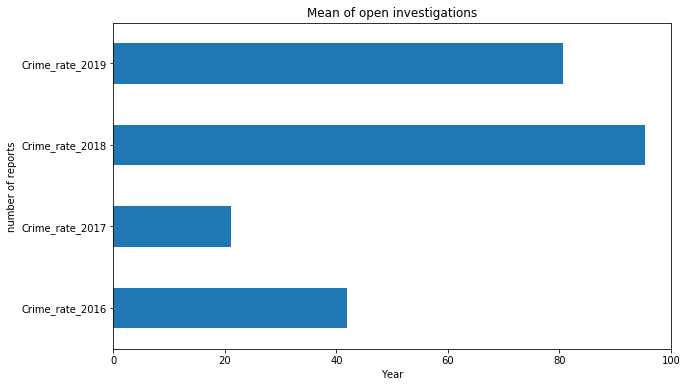

In [54]:
dffstats_years3['mean'].plot(kind='barh', figsize=(10, 6))

plt.xlabel('Year') # add to x-label to the plot
plt.ylabel('number of reports') # add y-label to the plot
plt.title('Mean of open investigations') # add title to the plot

plt.show()

By the graph above we can see a mean distribution, the highest one was on year 2018 with 95.33 open investigations.

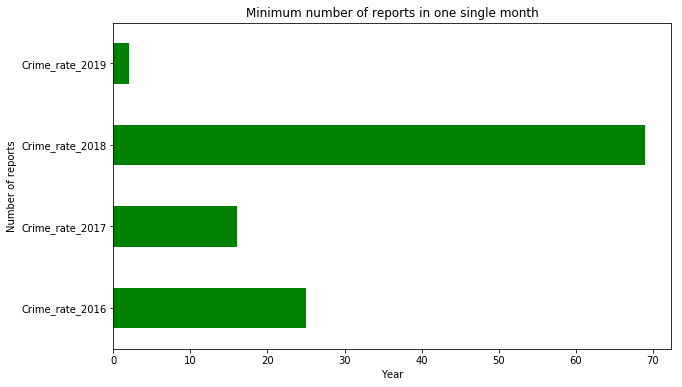

In [56]:
dffstats_years3['min'].plot(kind='barh', figsize=(10, 6), color='green')

plt.xlabel('Year') # add to x-label to the plot
plt.ylabel('Number of reports') # add y-label to the plot
plt.title('Minimum number of reports in one single month') # add title to the plot

plt.show()

By the graph above we can see thet 2019 was the year with less reports on a sinlge month, exactly on December 2019 with only 2

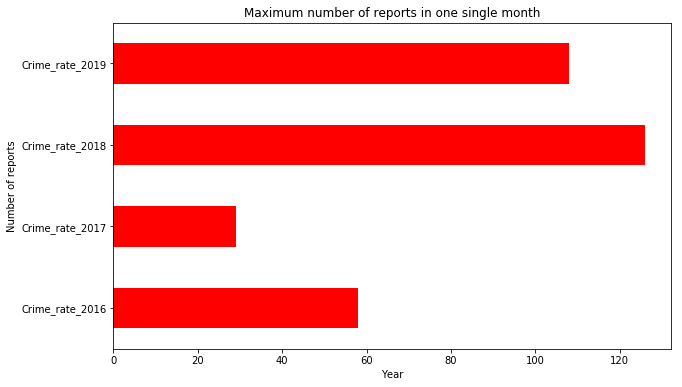

In [57]:
dffstats_years3['max'].plot(kind='barh', figsize=(10, 6), color='red')

plt.xlabel('Year') # add to x-label to the plot
plt.ylabel('Number of reports') # add y-label to the plot
plt.title('Maximum number of reports in one single month') # add title to the plot

plt.show()

By the graph above we can see that 2018 was the year with the highest number of reports on a sinlge month, exactly on January 2018 with 126 reports

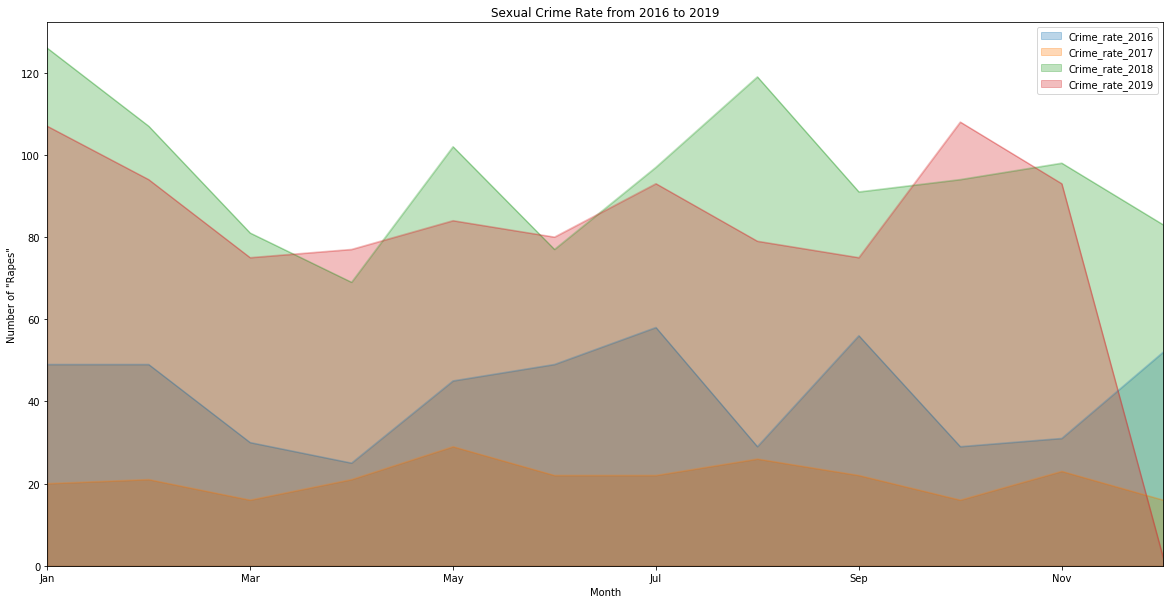

In [59]:
dffcomp.plot(kind='area', 
             alpha=0.3, # 0-1, default value a= 0.5
             stacked=False,
             figsize=(20, 10),
            )

plt.title('Sexual Crime Rate from 2016 to 2019')
plt.ylabel('Number of "Rapes"')
plt.xlabel('Month')

plt.show()

The graph above shows the behavior of the reported sexual crimes respect time, during the past 4 years we can see significant peaks on years 2016 and 2018 respectively

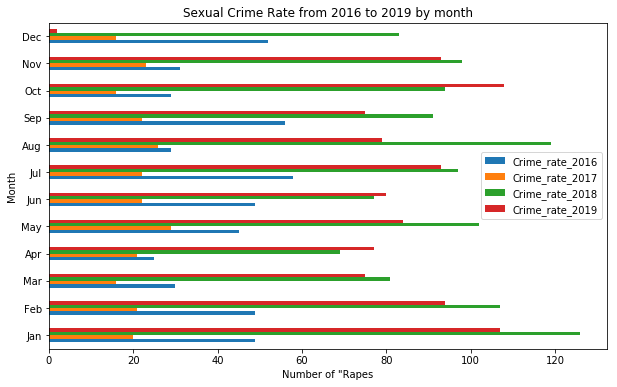

In [87]:
dffcomp.plot(kind='barh', figsize=(10, 6))

plt.xlabel('Number of "Rapes') # add to x-label to the plot
plt.ylabel('Month') # add y-label to the plot
plt.title('Sexual Crime Rate from 2016 to 2019 by month') # add title to the plot

plt.show()

The graph above shows the behavior of the reported sexual crimes **every month** during the past 4 years it is another perspective for the area plot

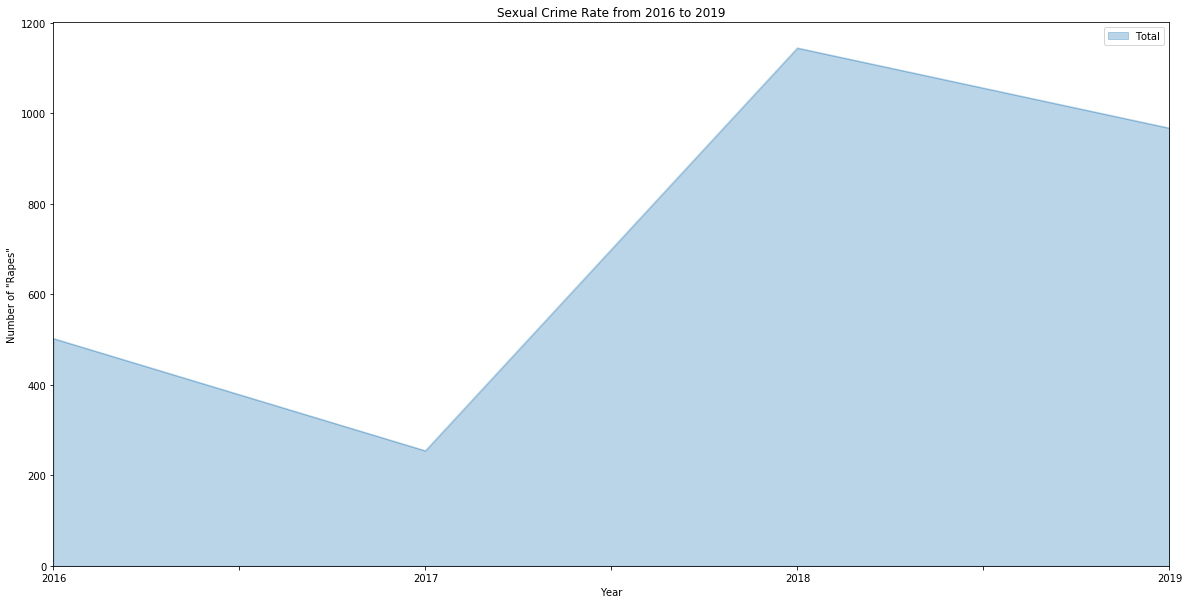

In [63]:
df_yearss.plot(kind='area', 
             alpha=0.3, # 0-1, default value a= 0.5
             stacked=False,
             figsize=(20, 10),
            )

plt.title('Sexual Crime Rate from 2016 to 2019')
plt.ylabel('Number of "Rapes"')
plt.xlabel('Year')

plt.show()

The graph above shows the behavior of the reported sexual crimes **by year** during the past 4 years.

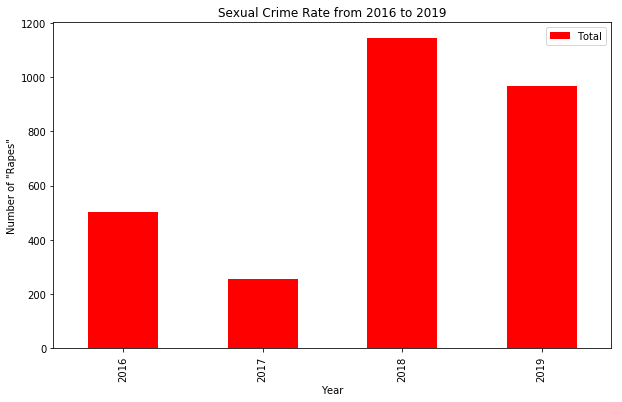

In [75]:
df_yearss.plot(kind='bar', figsize=(10, 6), color='red')

plt.xlabel('Year') # add to x-label to the plot
plt.ylabel('Number of "Rapes"') # add y-label to the plot
plt.title('Sexual Crime Rate from 2016 to 2019') # add title to the plot
plt.show()

The graph above shows the behavior of the reported sexual crimes **by year** during the past 4 years, we can see that **2018 was the most dangerous year for women with 1144 reported Rapes**.

In [90]:
dffcomp1=dffcomp
dffcomp1['Total']=dffcomp1.sum(axis=1)

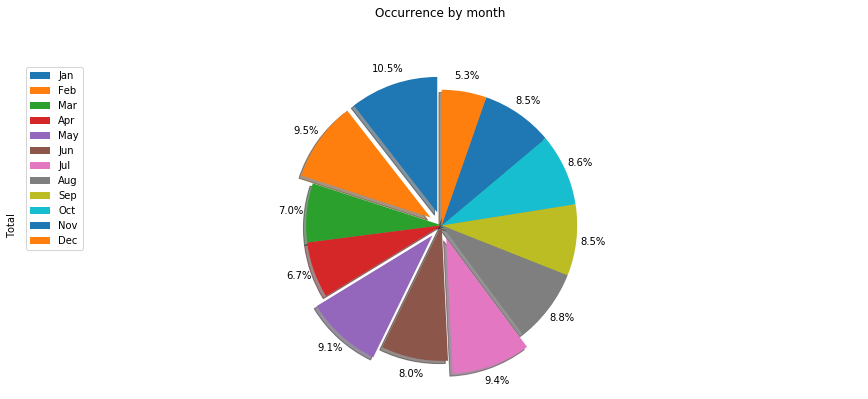

In [91]:
# autopct create %, start angle represent starting point
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen']
explode_list = [0.1, 0.1, 0, 0,0.1,0,0.1,0,0,0,0,0] # ratio for each continent with which to offset each wedge.

dffcomp1['Total'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Occurrence by month', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=dffcomp1.index, loc='upper left') 

plt.show()

The pie chart above shows the crime occurrence by month being the most active ones:"January, February, May and July" with **more tan 9 percent of occurrence each.** 

## Now we will plot all the insights by Borough a.k.a "Alcaldia"

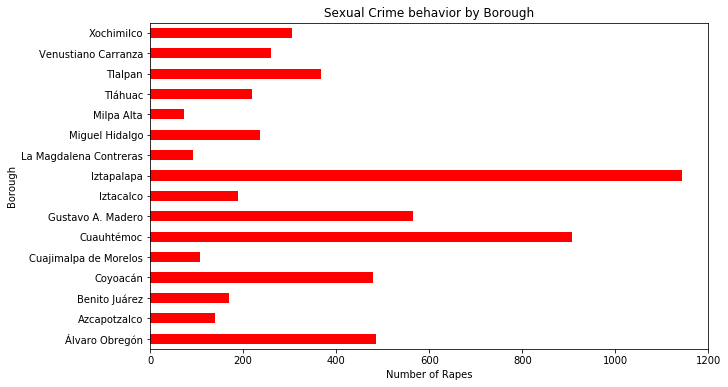

In [97]:
dffcomp_alc2['Total'].plot(kind='barh', figsize=(10, 6), color='red')

plt.xlabel('Number of Rapes') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('Sexual Crime behavior by Borough') # add title to the plot
plt.show()

On the graph above we can see that the most dangerous boroughs are Iztapalapa and Cuauhtemoc with 1142 and 906 open investigations respectively since 2016 to 2019.

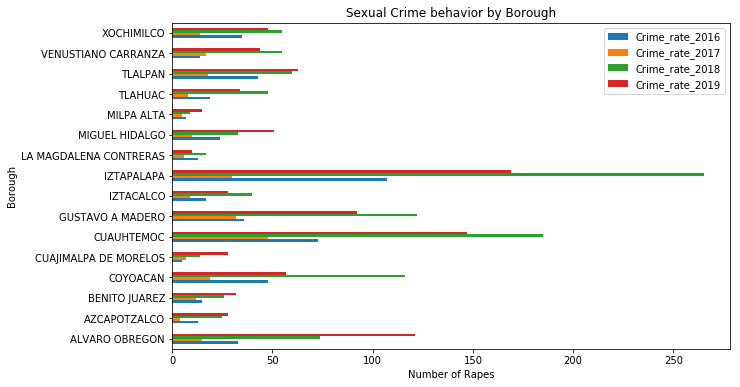

In [96]:
dffcomp_alc.plot(kind='barh', figsize=(10, 6))

plt.xlabel('Number of Rapes') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('Sexual Crime behavior by Borough') # add title to the plot
plt.show()

Even during the four years,Iztapalapa and Cuauhtemoc keep the title of most dangerous zones both with significant peaks on year 2018

# Finally we will plot the most important thing on this project, the awareness maps!

First we will plot the **cluster Map**

In [128]:
#Mexico City Coordinates
latitude = 19.42847
longitude = -99.12766

rape_risk_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around cdmx

# add the crime zones as red circle markers
for lat, lng, label in zip(dff1.latitud, dff1.longitud, dff1.delito):
    folium.features.CircleMarker(
        [lat, lng],
        radius=2,
        color='red',
        popup=label,
        fill = True,
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(rape_risk_map)

# display map
rape_risk_map

For this map above we can overlook the ocurrence around the city, each point represents a violent sexual attack, **almost the entire city is covered with them.**

In [129]:
from folium import plugins

# let's start again with a clean copy of the map of San Francisco
Mexcity_map = folium.Map(location = [19.42847, -99.12766], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
delitos = plugins.MarkerCluster().add_to(Mexcity_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(dff1.latitud, dff1.longitud, dff1.delito):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(delitos)

# display map
Mexcity_map

This map above we can overlook the occurrence around the city, each point represents a violent sexual attack, **almost the entire city is covered with them** and for aesthetic purposes we have clustered the crimes

Now we will plot the **Choropleth maps**

In [112]:
#We reset the index Alcaldia in order to plot
dffcomp_alc2.reset_index(inplace=True)

In [119]:
!wget --quiet https://raw.githubusercontent.com/ErikDelgadilloL/-Coursera_Capstone/master/alcaldias.geojson -O alcaldias_cdmx.geojson

In [120]:
alcaldias_geo = r'alcaldias_cdmx.geojson' # geojson file

In [121]:
# create a plain map of cdmx
cdmx_map = folium.Map(location=[19.42847, -99.12766], zoom_start=10,tiles='Mapbox Bright')

In [122]:
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
cdmx_map.choropleth(
    geo_data=alcaldias_geo,
    data= dffcomp_alc2,
    columns=['Alcaldia', 'Total'],
    key_on='feature.properties.nomgeo',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Sexual crimes on Mexico City',
)

# display map
cdmx_map

This map above is the graphical representation of all the 16 Boroughs in Mexico city and the level of reported crimes in each one, being **Iztapalapa** the darker one indeed.

In [123]:
# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(dffcomp_alc2['Total'].min(),
                              dffcomp_alc2['Total'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration
# let Folium determine the scale.
mexmap_map = folium.Map(location=[19.42847, -99.12766],
                        zoom_start=10,
                        tiles='Stamen Terrain')
mexmap_map.choropleth(
    geo_data=alcaldias_geo,
    data=dffcomp_alc2,
    columns=['Alcaldia', 'Total'],
    key_on='feature.properties.nomgeo',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Sexual crimes on Mexico City',
    reset=True
)
mexmap_map

This map above is the graphical representation of all the 16 Boroughs in Mexico city with the terrain and names view, **very usefull to find the level risk on every corner of the city**.

## Results and Discussion <a name="results"></a>

Our analysis shows that the Sexual Assault crime has had a constant and **continuous grow trough the last 5 years**, we can se on charts that the **year 2018 was by far the most dangerous year of the past lustrum**, we now have clear insights that **"Iztapalapa", "Cuahutemoc and "Alvaro Obregon" are the 3 most dangerous "Boroughs"** of the entire city and it is not a coincidence that the 3 of them are on the **northeast side of the city**, adjoining "Estado de México" another well known "High risk Mexican state, by plotting the "point" map i personally feel concerned about that **almost all Neighborhoods had at least 1 open investigation on Sexual assault** only speaking on the past year 2019, the past November the governor of Mexico City: **PhD. Claudia Sheinbaum** declared an **state of emergency called: "Gender Violence Alert"**,those actions in addition to all non-pacific protest around the city summoned by the pro feminist groups, were **immediately reflected in the numbers of December 2019** when **only 2 open investigations were considered on the category of "rape"**.

## Conclusion <a name="conclusion"></a>

I consider that this is a very alarming situation and by doing this project I'm looking forward into unravel the information to every woman and men who lives or practice tourism around the city, before elaborating this project i searched for a map about this topic, but although all the information available it didn't exist at all, i hope this problem gets a lot better on the coming years, **thanks for reading.**